# Licitações — Análise de Duração por Modalidade, Período e UF

Este notebook analisa a duração dos processos licitatórios, comparando a modalidade **Dispensa de Licitação** com as demais modalidades,
segmentando os resultados por período normativo e por UF.


<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/04-oec/licitacap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importações e Configurações Gerais

Configuração de bibliotecas e estilo de visualização.

Este bloco organiza o ambiente de análise com bibliotecas estatísticas e gráficas, garantindo consistência visual.
A padronização de estilo facilita a comparação entre gráficos ao longo do estudo.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações visuais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## Leitura e Consolidação dos Dados

Leitura de todos os arquivos CSV do diretório `dados/`, com tratamento de encoding e consolidação em um único dataframe.

Os arquivos são lidos diretamente do diretório `dados/` para cobrir todo o período disponível.
O uso de `cp1252` com fallback para `cp1250` evita falhas de leitura e preserva caracteres acentuados.
A consolidação em um único dataframe permite análises globais e segmentadas sem perda de granularidade.

In [2]:
# Definição dos arquivos de entrada
arquivos_alvo = sorted(
    os.path.join('dados', f)
    for f in os.listdir('dados')
    if f.lower().endswith('.csv')
)

lista_df = []

# Processamento de leitura
for arquivo in arquivos_alvo:
    if os.path.exists(arquivo):
        print(f"Processando: {arquivo}")
        # Lendo com os parâmetros corretos de separador e encoding
        try:
            temp_df = pd.read_csv(arquivo, sep=';', encoding='cp1252', low_memory=False)
        except UnicodeDecodeError:
            temp_df = pd.read_csv(arquivo, sep=';', encoding='cp1250', low_memory=False)
        lista_df.append(temp_df)
    else:
        print(f"Erro: Arquivo {arquivo} não encontrado.")

# União e salvamento
if lista_df:
    df = pd.concat(lista_df, ignore_index=True)
    arquivo_saida = "Licitacoes_Consolidado.csv"
    df.to_csv(arquivo_saida, sep=';', encoding='utf-8', index=False)

    print("-" * 30)
    print(f"Sucesso! Total de registros: {len(df)}")
else:
    print("Falha: Nenhum dado foi carregado.")


Processando: dados/201901_Licitação.csv
Processando: dados/201902_Licitação.csv
Processando: dados/201903_Licitação.csv
Processando: dados/201904_Licitação.csv
Processando: dados/201905_Licitação.csv
Processando: dados/201906_Licitação.csv
Processando: dados/201907_Licitação.csv
Processando: dados/201908_Licitação.csv
Processando: dados/201909_Licitação.csv
Processando: dados/201910_Licitação.csv
Processando: dados/201911_Licitação.csv
Processando: dados/201912_Licitação.csv
Processando: dados/202001_Licitação.csv
Processando: dados/202002_Licitação.csv
Processando: dados/202003_Licitação.csv
Processando: dados/202004_Licitação.csv
Processando: dados/202005_Licitação.csv
Processando: dados/202006_Licitação.csv
Processando: dados/202007_Licitação.csv
Processando: dados/202008_Licitação.csv
Processando: dados/202009_Licitação.csv
Processando: dados/202010_Licitação.csv
Processando: dados/202011_Licitação.csv
Processando: dados/202012_Licitação.csv
Processando: dados/202101_Licitação.csv


In [3]:
df.describe()

,Número Licitação,Código UG,Código Modalidade Compra,Código Órgão Superior,Código Órgão
count,6.369610e+05,636961.000000,636961.000000,636961.000000,636961.000000
mean,1.739209e+07,253736.049472,1417.586906,39279.551888,38720.779473
std,1.004007e+08,211246.985503,3480.399828,13298.150709,13833.696071
min,1.201300e+04,30100.000000,1.000000,3000.000000,3000.000000
25%,1.220190e+05,154047.000000,6.000000,26000.000000,26263.000000
50%,3.820210e+05,160199.000000,6.000000,36000.000000,36000.000000
75%,1.142020e+06,240003.000000,7.000000,52000.000000,52121.000000
max,9.999320e+08,930182.000000,9999.000000,96111.000000,96111.000000


## Limpeza e Preparação dos Dados

Conversão de valores, padronização de datas e criação da variável de duração.

A limpeza padroniza valores numéricos e converte datas com `dayfirst=True`, compatível com o formato brasileiro.
A duração do processo é calculada como a diferença entre `Data_Resultado_Compra` e `Data_Abertura`.
Registros com duração negativa ou datas inválidas são filtrados nas análises posteriores para evitar distorções.

In [4]:
# 1. Tratamento da coluna de Valor

df = df.rename(columns={"Valor Licitação": "Valor_Licitacao"})
df = df.rename(columns={"Data Resultado Compra": "Data_Resultado_Compra"})
df = df.rename(columns={"Data Abertura": "Data_Abertura"})
df = df.rename(columns={"Modalidade Compra": "Modalidade_Compra"})

# Removemos a vírgula e convertemos para numérico
df['Valor_Licitacao'] = (
    df['Valor_Licitacao']
    .astype(str)
    .str.replace(',', '.')
)
df['Valor_Licitacao'] = pd.to_numeric(df['Valor_Licitacao'], errors='coerce')

# 2. Tratamento das colunas de Data
colunas_data = ['Data_Resultado_Compra', 'Data_Abertura']
for col in colunas_data:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# 3. Cálculo da Duração (Feature Engineering)
df['Duracao_dias'] = (df['Data_Resultado_Compra'] - df['Data_Abertura']).dt.days

# 4. Normalização de modalidades e agrupamento

df['Modalidade_norm'] = (
    df['Modalidade_Compra']
    .astype(str)
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.strip()
)

df['Grupo_Modalidade'] = np.select(
    [
        df['Modalidade_norm'].str.contains('DISPENSA', na=False),
        df['Modalidade_norm'].str.contains('PREGAO', na=False),
    ],
    [
        'Dispensa',
        'Pregão',
    ],
    default='Outras'
)

# 5. Tratamento de UF inválida (-3)
df['UF'] = df['UF'].replace({-3: 'DF', '-3': 'DF'})

# Verificação final dos tipos
print("Novos tipos de dados nas colunas principais:")
print(df[['Valor_Licitacao', 'Data_Resultado_Compra', 'Data_Abertura', 'Duracao_dias']].dtypes)
print(f"Valores nulos encontrados na Duração: {df['Duracao_dias'].isna().sum()}")


Novos tipos de dados nas colunas principais:
Valor_Licitacao                 float64
Data_Resultado_Compra    datetime64[ns]
Data_Abertura            datetime64[ns]
Duracao_dias                    float64
dtype: object
Valores nulos encontrados na Duração: 440094


## Análise da Celeridade

Estatísticas descritivas e comparações entre modalidades, incluindo distribuições e gráficos.

As estatísticas descritivas por modalidade oferecem uma visão da distribuição da duração dos processos.
Boxplots e dispersões revelam assimetrias, outliers e diferenças estruturais entre modalidades.
A análise específica de Dispensa complementa a comparação ao evidenciar padrões de duração.


In [5]:
# 1. Criando o resumo novamente (garantindo que os dados estão limpos)
resumo_estatistico = df.groupby('Grupo_Modalidade').agg({
    'Valor_Licitacao': ['count', 'mean', 'sum'],
    'Duracao_dias': 'mean'
}).reset_index()

# 2. Renomeando
resumo_estatistico.columns = [
    'Modalidade',
    'Qtd_Processos',
    'Valor_Medio',
    'Valor_Total',
    'Media_Dias_Processo'
]

# 3. Tratamento de NaNs (substitui por 0 onde não foi possível calcular a duração)
resumo_estatistico['Media_Dias_Processo'] = resumo_estatistico['Media_Dias_Processo'].fillna(0)

# 4. Ordenação
resumo_estatistico = resumo_estatistico.sort_values(by='Qtd_Processos', ascending=False)

# 5. Exibição Formatada (Sem notação científica e com separadores)
formatacao = {
    'Valor_Medio': 'R$ {:,.2f}',
    'Valor_Total': 'R$ {:,.2f}',
    'Media_Dias_Processo': '{:.1f} dias',
    'Qtd_Processos': '{:,}'
}

# Exibindo a tabela estilizada
resumo_estatistico.style.format(formatacao).hide(axis='index')


Modalidade,Qtd_Processos,Valor_Medio,Valor_Total,Media_Dias_Processo
Dispensa,"391,834","R$ 252,873.94","R$ 99,084,609,063.11",21.9 dias
Pregão,"150,196","R$ 24,925,172.78","R$ 3,743,661,250,589.11",33.1 dias
Outras,"94,931","R$ 1,222,656.91","R$ 116,068,043,228.08",0.0 dias


/tmp/ipykernel_1919/2791873590.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


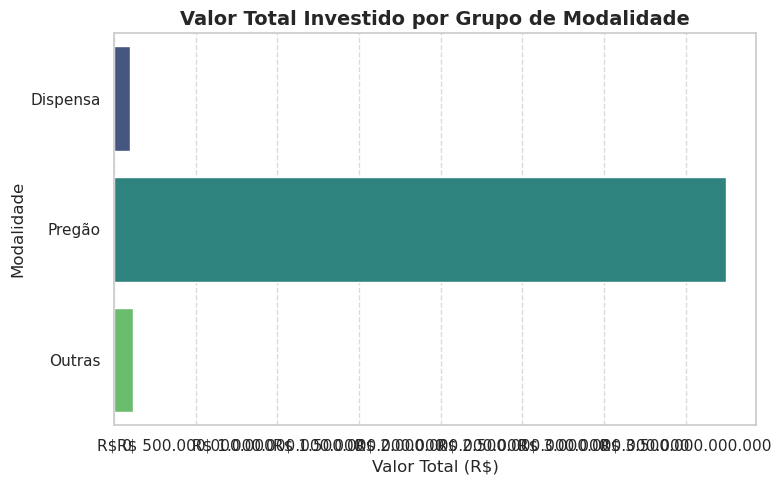

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=resumo_estatistico,
    x='Valor_Total',
    y='Modalidade',
    palette='viridis'
)

# Formatação de Moeda (R$) no eixo X
formatter = mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
ax.xaxis.set_major_formatter(formatter)

plt.title('Valor Total Investido por Grupo de Modalidade', fontsize=14, fontweight='bold')
plt.xlabel('Valor Total (R$)', fontsize=12)
plt.ylabel('Modalidade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


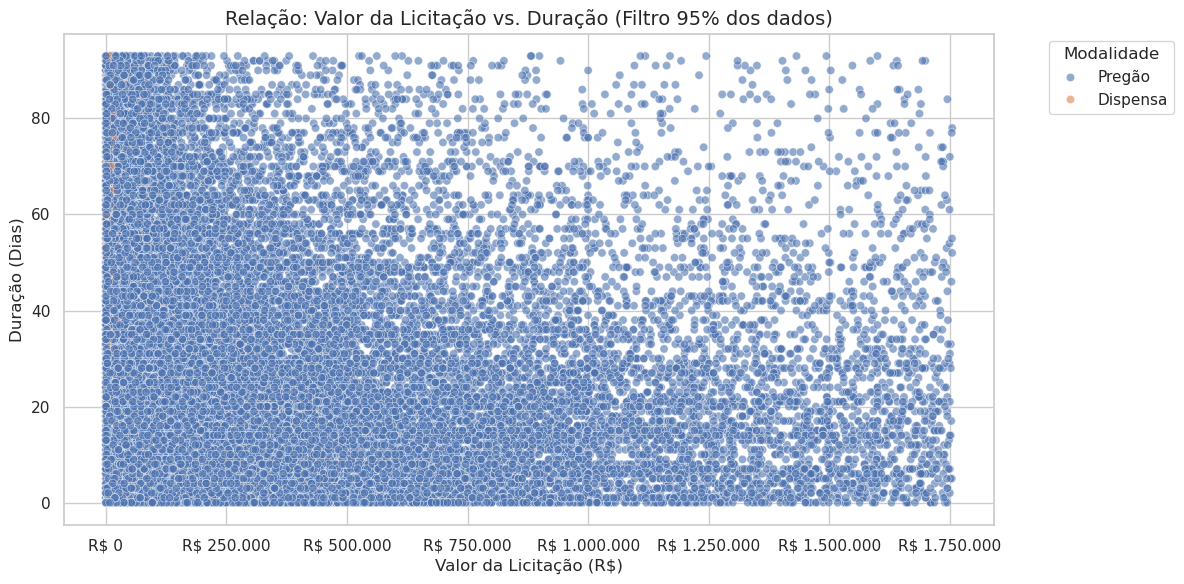

In [7]:
df_plot = df[(df['Valor_Licitacao'] > 0) & (df['Duracao_dias'] >= 0)].copy()

limite_valor = df_plot['Valor_Licitacao'].quantile(0.95)
limite_dias = df_plot['Duracao_dias'].quantile(0.95)

df_filtrado = df_plot[(df_plot['Valor_Licitacao'] <= limite_valor) & (df_plot['Duracao_dias'] <= limite_dias)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_filtrado,
    x='Valor_Licitacao',
    y='Duracao_dias',
    hue='Grupo_Modalidade',
    alpha=0.6
)

plt.title('Relação: Valor da Licitação vs. Duração (Filtro 95% dos dados)', fontsize=14)
plt.xlabel('Valor da Licitação (R$)', fontsize=12)
plt.ylabel('Duração (Dias)', fontsize=12)

# Formatação do eixo X como moeda
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)

plt.legend(title='Modalidade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


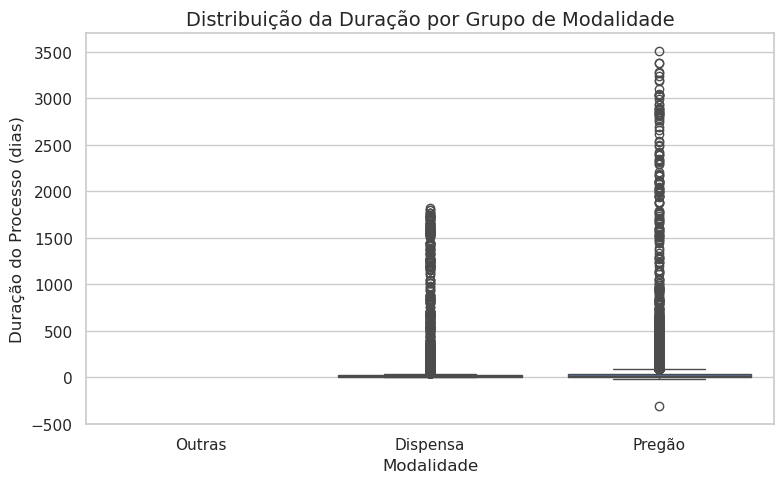

In [8]:
#  Distribuição da duração por grupo de modalidade (Boxplot)

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df,
    x='Grupo_Modalidade',
    y='Duracao_dias'
)

plt.title('Distribuição da Duração por Grupo de Modalidade', fontsize=14)
plt.xlabel('Modalidade', fontsize=12)
plt.ylabel('Duração do Processo (dias)', fontsize=12)

plt.tight_layout()
plt.show()


In [9]:
# Detecção de casos anômalos

# Calculando o limite superior do top 10% mais demorado
p90 = df['Duracao_dias'].quantile(0.90)

print(f"Percentil 90 da duração: {p90:.2f} dias")

# Criando coluna indicadora de possível reprocesso
df['Possivel_Reprocesso'] = df['Duracao_dias'] > p90

# Estatísticas por modalidade e grupo
resultado_analise = df.groupby(['Grupo_Modalidade', 'Possivel_Reprocesso'])['Duracao_dias']                       .agg(['count', 'mean', 'median']).reset_index()

print("Resumo da análise de reprocessos:")
print(resultado_analise)


Percentil 90 da duração: 65.00 dias
Resumo da análise de reprocessos:
  Grupo_Modalidade  Possivel_Reprocesso   count        mean  median
0         Dispensa                False   45169   13.714118    10.0
1         Dispensa                 True    1509  266.241219   105.0
2           Outras                False       0         NaN     NaN
3           Pregão                False  132029   18.129509    14.0
4           Pregão                 True   18160  142.105892   101.0


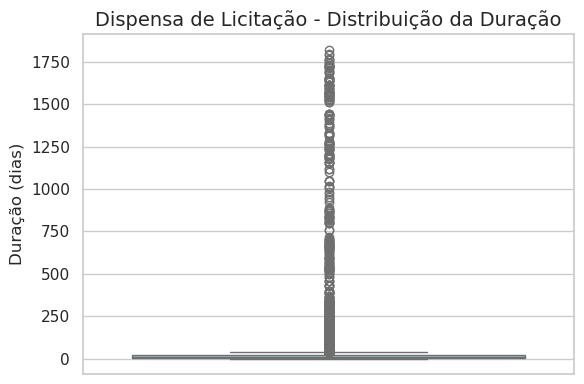

Gráfico 1 salvo como: boxplot_dispensa.png


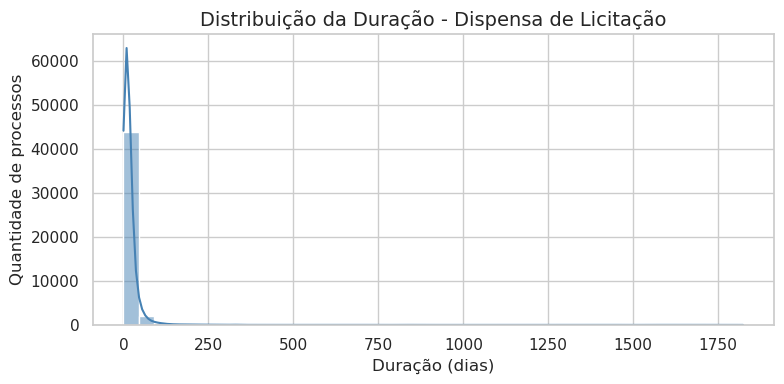

Gráfico 2 salvo como: histograma_dispensa.png


In [10]:
# Filtrar apenas dispensa
df_dispensa = df[df['Grupo_Modalidade'] == 'Dispensa']

# 1) Boxplot da Dispensa
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_dispensa['Duracao_dias'], color='skyblue')
plt.title('Dispensa de Licitação - Distribuição da Duração', fontsize=14)
plt.ylabel('Duração (dias)')
plt.tight_layout()
plt.savefig('boxplot_dispensa.png', dpi=300)
plt.show()

print("Gráfico 1 salvo como: boxplot_dispensa.png")


# 2) Histograma da duração da Dispensa
plt.figure(figsize=(8, 4))
sns.histplot(df_dispensa['Duracao_dias'], bins=40, kde=True, color='steelblue')
plt.title('Distribuição da Duração - Dispensa de Licitação', fontsize=14)
plt.xlabel('Duração (dias)')
plt.ylabel('Quantidade de processos')
plt.tight_layout()
plt.savefig('histograma_dispensa.png', dpi=300)
plt.show()

print("Gráfico 2 salvo como: histograma_dispensa.png")


## Novas Analises: Tendencia Temporal e Faixas de Valor

Explora como a duracao dos processos evolui ao longo do tempo e como varia por faixas de valor.

In [ ]:
# Tendencia temporal: mediana de duracao por ano de abertura

df_tempo = df[(df['Duracao_dias'] >= 0) & (df['Data_Abertura'].notna())].copy()
df_tempo['Ano_Abertura'] = df_tempo['Data_Abertura'].dt.year

mediana_ano = (
    df_tempo
    .groupby(['Ano_Abertura', 'Grupo_Modalidade'])['Duracao_dias']
    .median()
    .reset_index()
    .sort_values('Ano_Abertura')
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=mediana_ano,
    x='Ano_Abertura',
    y='Duracao_dias',
    hue='Grupo_Modalidade',
    marker='o'
)
plt.title('Mediana da Duracao por Ano de Abertura')
plt.xlabel('Ano')
plt.ylabel('Dias')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Proporcao de processos com duracao > 6 meses por ano
prop_longos = (
    df_tempo
    .groupby(['Ano_Abertura', 'Grupo_Modalidade'])
    .apply(lambda x: (x['Duracao_dias'] > 180).mean())
    .reset_index(name='Proporcao')
    .sort_values('Ano_Abertura')
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=prop_longos,
    x='Ano_Abertura',
    y='Proporcao',
    hue='Grupo_Modalidade',
    marker='o'
)
plt.title('Proporcao de Processos com Duracao Superior a 6 Meses por Ano')
plt.xlabel('Ano')
plt.ylabel('Proporcao')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Faixas de valor: mediana de duracao por quintis de valor

df_valor = df[(df['Valor_Licitacao'] > 0) & (df['Duracao_dias'] >= 0)].copy()

df_valor['Faixa_Valor'] = pd.qcut(
    df_valor['Valor_Licitacao'],
    q=5,
    duplicates='drop'
)

mediana_faixa = (
    df_valor
    .groupby(['Faixa_Valor', 'Grupo_Modalidade'])['Duracao_dias']
    .median()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=mediana_faixa,
    x='Faixa_Valor',
    y='Duracao_dias',
    hue='Grupo_Modalidade'
)
plt.title('Mediana da Duracao por Faixa de Valor da Licitacao')
plt.xlabel('Faixa de Valor (quintis)')
plt.ylabel('Dias')
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Períodos Normativos e Segmentação por UF

Classificação dos processos por fase normativa, comparação Dispensa vs Outras e segmentação por UF.

A classificação normativa usa `Data_Resultado_Compra` com cortes em 01/04/2021 e 01/01/2024,
respeitando o período de transição e a vigência plena da Lei nº 14.133/2021.
A segmentação por UF permite identificar diferenças regionais na duração e na distribuição de modalidades.
A comparação `Dispensa` vs `Outras` simplifica a leitura e ressalta o papel da dispensa no tempo de contratação.

In [11]:
# --- Analises por fase normativa (base temporal conforme ProjetoOrganizado) ---

# Fase 1: Lei 8.666 (01/01/2019 a 30/04/2021) com base em Data_Abertura
df_8666 = df[
    (df['Data_Abertura'] >= '2019-01-01') &
    (df['Data_Abertura'] <= '2021-04-30') &
    (df['Duracao_dias'].notna()) &
    (df['Duracao_dias'] >= 0)
]

# Fase 2: Transição (01/05/2021 a 31/12/2023) com base em Data_Abertura
df_transicao = df[
    (df['Data_Abertura'] >= '2021-05-01') &
    (df['Data_Abertura'] <= '2023-12-31') &
    (df['Duracao_dias'].notna()) &
    (df['Duracao_dias'] >= 0)
]

# Fase 3: Lei 14.133 (base em Data_Resultado_Compra)
df_14133 = df[
    (df['Data_Resultado_Compra'] >= '2023-01-01') &
    (df['Duracao_dias'].notna()) &
    (df['Duracao_dias'] >= 0)
]

# Recorte 2024
df_2024 = df_14133[df_14133['Data_Resultado_Compra'].dt.year == 2024]

print(f"Registros na Fase 1 (Lei 8.666): {len(df_8666)}")
print(f"Registros no Período de Transição: {len(df_transicao)}")
print(f"Registros na Fase 3 (Lei 14.133): {len(df_14133)}")
print(f"Registros em 2024: {len(df_2024)}")


Registros na Fase 1 (Lei 8.666): 89276
Registros no Período de Transição: 101291
Registros na Fase 3 (Lei 14.133): 37225
Registros em 2024: 6151


In [12]:
# Estatísticas descritivas — Lei 8.666
estatisticas_8666 = (
    df_8666
    .groupby('Grupo_Modalidade')['Duracao_dias']
    .agg(
        Quantidade='count',
        Media_Dias='mean',
        Mediana_Dias='median',
        P25=lambda x: x.quantile(0.25),
        P75=lambda x: x.quantile(0.75),
        Acima_6_Meses=lambda x: (x > 180).sum(),
        Acima_1_Ano=lambda x: (x > 365).sum()
    )
    .round(2)
)

display(estatisticas_8666)


,Quantidade,Media_Dias,Mediana_Dias,P25,P75,Acima_6_Meses,Acima_1_Ano
Grupo_Modalidade,,,,,,,
Dispensa,27317,23.21,10.0,6.0,19.0,228,156
Pregão,61959,32.13,17.0,6.0,38.0,1169,181


,UF,Grupo_Modalidade,Quantidade,Media_Dias,Mediana_Dias,Acima_6_Meses
0,AC,Dispensa,28,12.54,8.0,0
1,AC,Pregão,375,24.80,14.0,4
2,AL,Dispensa,155,12.57,8.0,0
3,AL,Pregão,636,30.23,18.5,7
4,AM,Dispensa,703,10.67,7.0,0
5,AM,Pregão,1645,35.78,20.0,38
6,AP,Dispensa,150,14.94,8.0,0
7,AP,Pregão,321,31.30,12.0,8
8,BA,Dispensa,682,15.56,8.0,1
9,BA,Pregão,1929,36.46,18.0,56


Total de UFs analisadas: 27


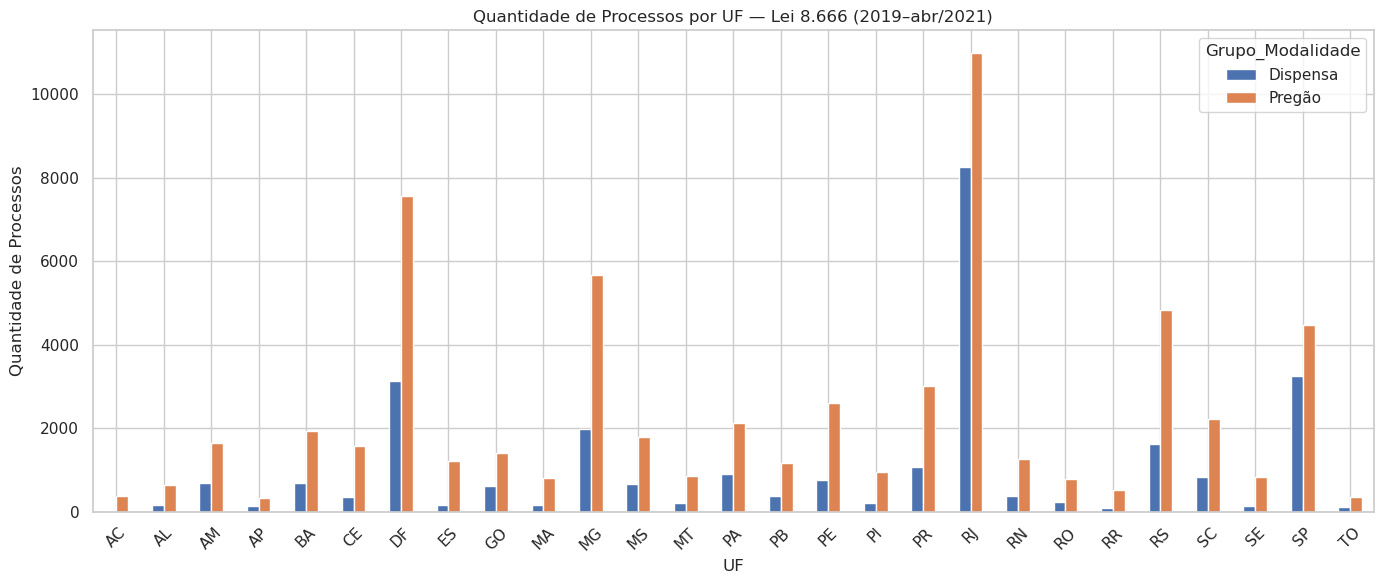

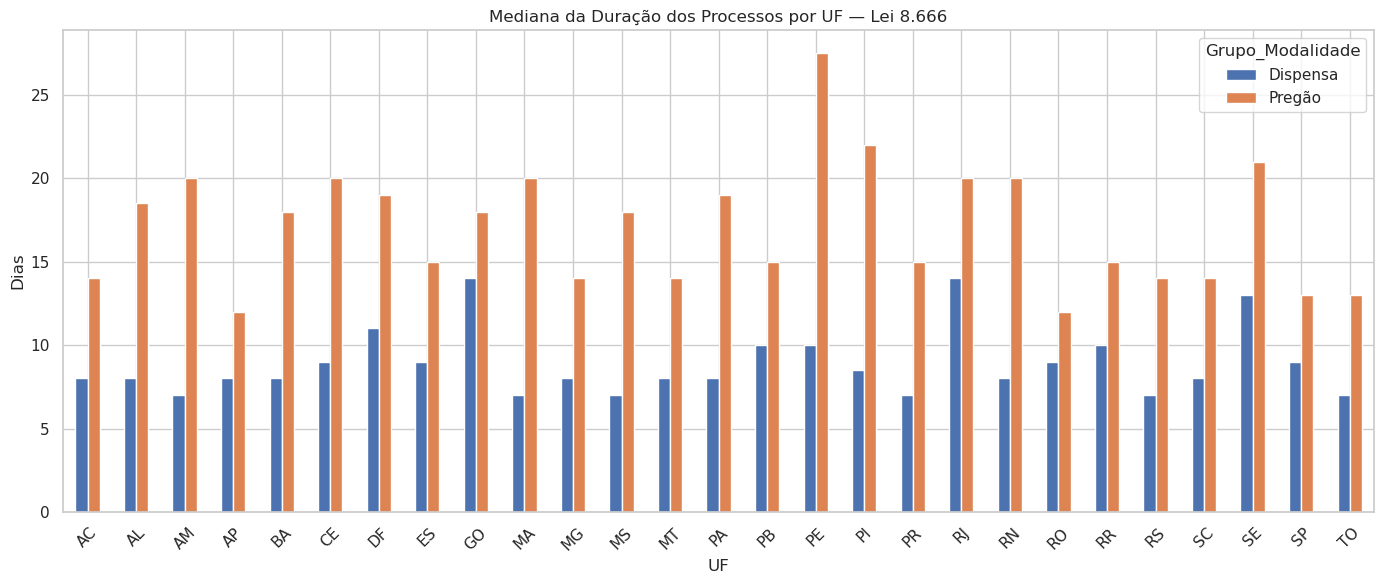

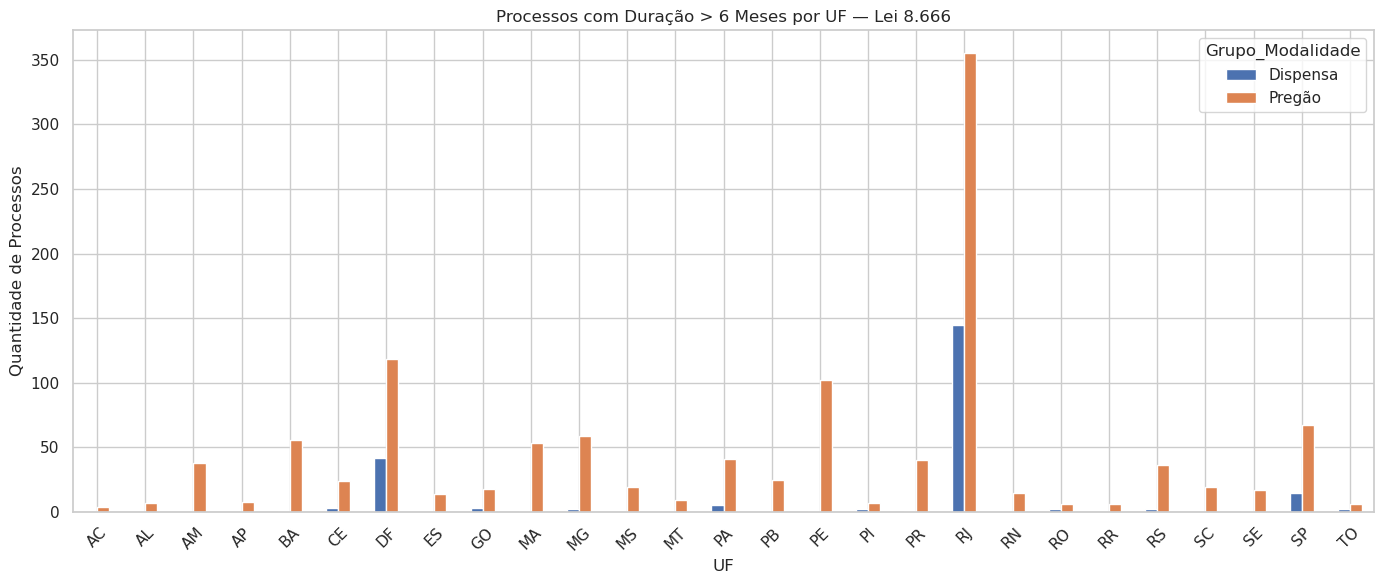

In [13]:
# Lei 8.666 — UF x Modalidade
estatisticas_8666_uf = (
    df_8666
    .groupby(['UF', 'Grupo_Modalidade'])['Duracao_dias']
    .agg(
        Quantidade='count',
        Media_Dias='mean',
        Mediana_Dias='median',
        Acima_6_Meses=lambda x: (x > 180).sum()
    )
    .reset_index()
    .round(2)
)

estatisticas_8666_uf = estatisticas_8666_uf.sort_values(['UF', 'Grupo_Modalidade'])

display(estatisticas_8666_uf)

print(f"Total de UFs analisadas: {estatisticas_8666_uf['UF'].nunique()}")

# Plot por UF — Quantidade
pivot_qtd = estatisticas_8666_uf.pivot(
    index='UF',
    columns='Grupo_Modalidade',
    values='Quantidade'
).fillna(0)

pivot_qtd.plot(kind='bar', figsize=(14, 6))
plt.title('Quantidade de Processos por UF — Lei 8.666 (2019–abr/2021)')
plt.ylabel('Quantidade de Processos')
plt.xlabel('UF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot por UF — Mediana
pivot_mediana = estatisticas_8666_uf.pivot(
    index='UF',
    columns='Grupo_Modalidade',
    values='Mediana_Dias'
)

pivot_mediana.plot(kind='bar', figsize=(14, 6))
plt.title('Mediana da Duração dos Processos por UF — Lei 8.666')
plt.ylabel('Dias')
plt.xlabel('UF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot por UF — Acima de 6 meses
pivot_atrasos = estatisticas_8666_uf.pivot(
    index='UF',
    columns='Grupo_Modalidade',
    values='Acima_6_Meses'
).fillna(0)

pivot_atrasos.plot(kind='bar', figsize=(14, 6))
plt.title('Processos com Duração > 6 Meses por UF — Lei 8.666')
plt.ylabel('Quantidade de Processos')
plt.xlabel('UF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,Quantidade,Media_Dias,Mediana_Dias,P25,P75,Acima_6_Meses,Acima_1_Ano
Grupo_Modalidade,,,,,,,
Dispensa,19186,18.85,11.0,7.0,19.0,159,63
Pregão,82105,28.46,15.0,6.0,35.0,1106,78


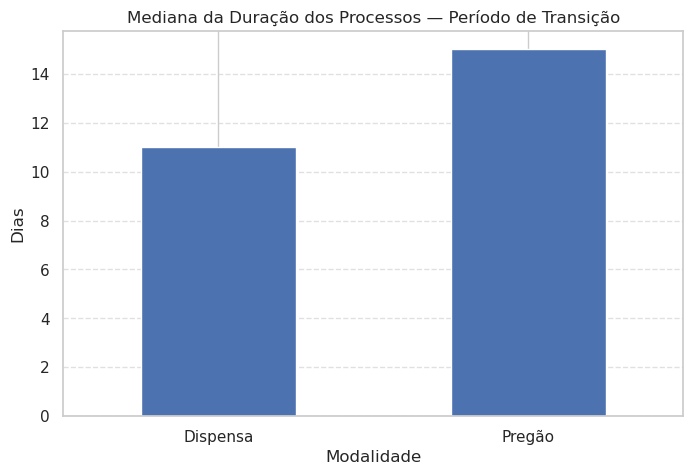

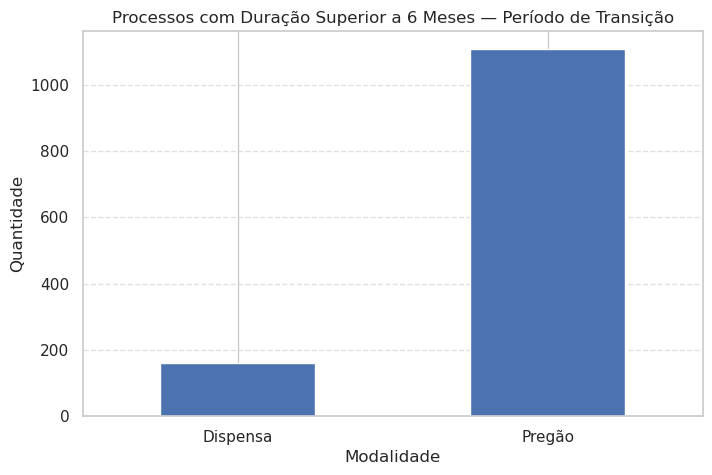

In [14]:
# Estatísticas descritivas — Período de Transição
estatisticas_transicao = (
    df_transicao
    .groupby('Grupo_Modalidade')['Duracao_dias']
    .agg(
        Quantidade='count',
        Media_Dias='mean',
        Mediana_Dias='median',
        P25=lambda x: x.quantile(0.25),
        P75=lambda x: x.quantile(0.75),
        Acima_6_Meses=lambda x: (x > 180).sum(),
        Acima_1_Ano=lambda x: (x > 365).sum()
    )
    .round(2)
)

display(estatisticas_transicao)

# Gráficos gerais do período de transição
estatisticas_transicao['Mediana_Dias'].plot(
    kind='bar',
    figsize=(8, 5),
    title='Mediana da Duração dos Processos — Período de Transição',
    ylabel='Dias',
    xlabel='Modalidade'
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

estatisticas_transicao['Acima_6_Meses'].plot(
    kind='bar',
    figsize=(8, 5),
    title='Processos com Duração Superior a 6 Meses — Período de Transição',
    ylabel='Quantidade',
    xlabel='Modalidade'
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


,UF,Grupo_Modalidade,Quantidade,Media_Dias,Mediana_Dias,Acima_6_Meses
0,AC,Dispensa,39,25.46,13.0,0
1,AC,Pregão,569,19.14,9.0,2
2,AL,Dispensa,119,15.86,9.0,0
3,AL,Pregão,832,31.03,17.0,11
4,AM,Dispensa,449,11.88,8.0,0
5,AM,Pregão,2477,25.83,15.0,21
6,AP,Dispensa,123,13.37,8.0,0
7,AP,Pregão,485,26.61,15.0,4
8,BA,Dispensa,415,16.12,8.0,3
9,BA,Pregão,2786,29.29,15.0,45


Total de UFs analisadas: 27


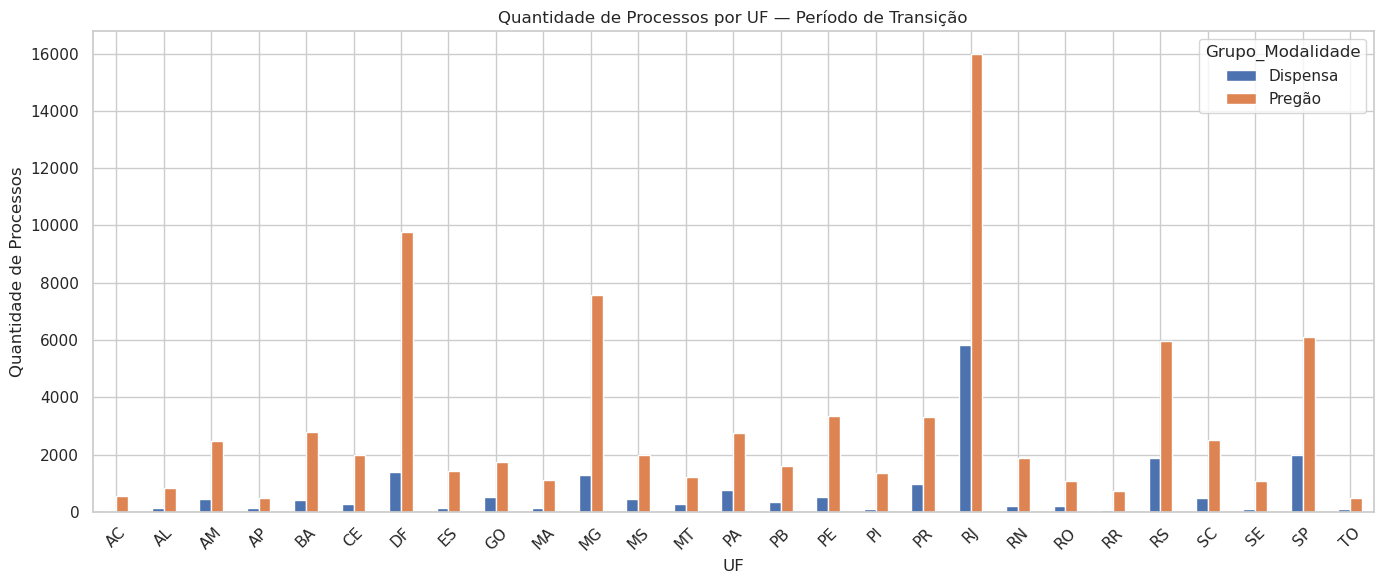

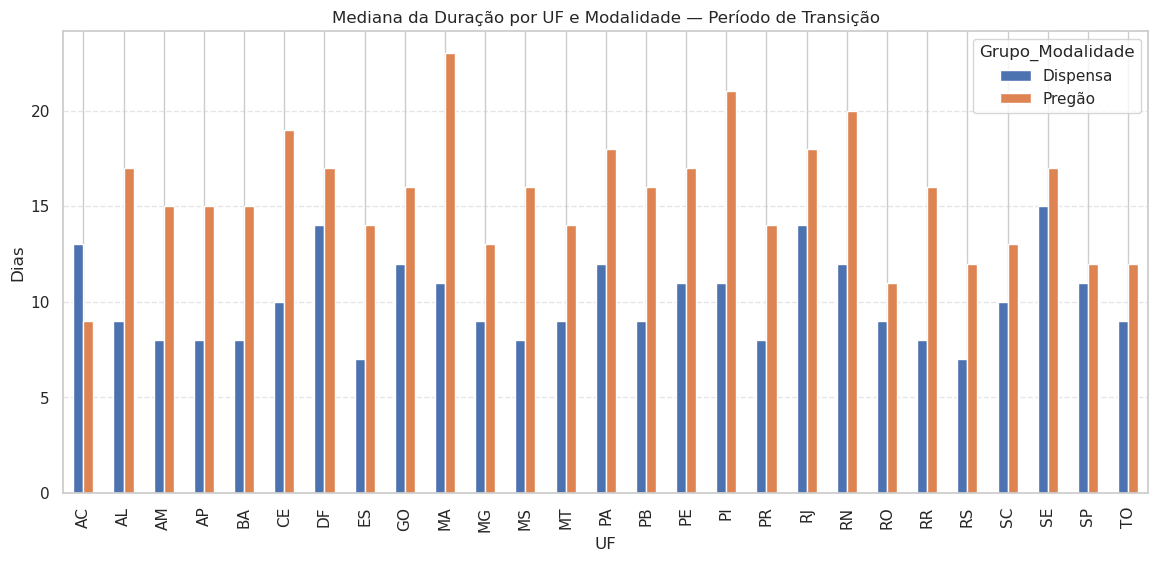

In [15]:
# Período de Transição — UF x Modalidade
estatisticas_transicao_uf = (
    df_transicao
    .groupby(['UF', 'Grupo_Modalidade'])['Duracao_dias']
    .agg(
        Quantidade='count',
        Media_Dias='mean',
        Mediana_Dias='median',
        Acima_6_Meses=lambda x: (x > 180).sum()
    )
    .reset_index()
    .round(2)
)

estatisticas_transicao_uf = estatisticas_transicao_uf.sort_values(['UF', 'Grupo_Modalidade'])

display(estatisticas_transicao_uf)

print(f"Total de UFs analisadas: {estatisticas_transicao_uf['UF'].nunique()}")

# Plot por UF — Quantidade (Transição)
pivot_qtd_transicao = estatisticas_transicao_uf.pivot(
    index='UF',
    columns='Grupo_Modalidade',
    values='Quantidade'
).fillna(0)

pivot_qtd_transicao.plot(kind='bar', figsize=(14, 6))
plt.title('Quantidade de Processos por UF — Período de Transição')
plt.ylabel('Quantidade de Processos')
plt.xlabel('UF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot por UF — Mediana (Transição)
df_plot_transicao = estatisticas_transicao_uf[
    estatisticas_transicao_uf['Grupo_Modalidade'].isin(['Dispensa', 'Pregão'])
]

pivot_mediana_transicao = df_plot_transicao.pivot(
    index='UF',
    columns='Grupo_Modalidade',
    values='Mediana_Dias'
)

pivot_mediana_transicao.plot(
    kind='bar',
    figsize=(14, 6),
    title='Mediana da Duração por UF e Modalidade — Período de Transição',
    ylabel='Dias'
)

plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Registros na Fase 3 (Lei 14.133): 37225


Grupo_Modalidade
Pregão      34643
Dispensa     2582
Name: count, dtype: int64

/tmp/ipykernel_1919/361889851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Ano_Abertura'] = df_2024['Data_Abertura'].dt.year


Ano_Abertura
2024    3609
2023    2371
2019      62
2020      50
2022      34
2021      25
Name: count, dtype: int64

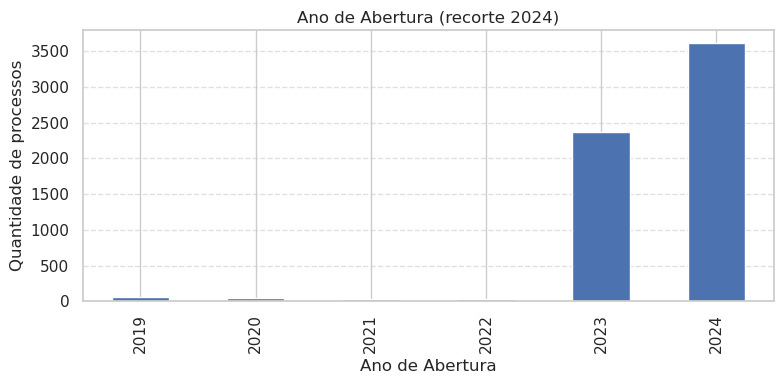

In [16]:
# Lei 14.133 — Recorte 2024

print(f"Registros na Fase 3 (Lei 14.133): {len(df_14133)}")

# Distribuição por grupo de modalidade
display(df_14133['Grupo_Modalidade'].value_counts())

# Ano de abertura no recorte 2024
df_2024['Ano_Abertura'] = df_2024['Data_Abertura'].dt.year

display(df_2024['Ano_Abertura'].value_counts(dropna=False))

# Visualização: distribuição do Ano_Abertura em 2024
df_2024['Ano_Abertura'].value_counts(dropna=False).sort_index().plot(
    kind='bar',
    figsize=(8, 4),
    title='Ano de Abertura (recorte 2024)'
)
plt.xlabel('Ano de Abertura')
plt.ylabel('Quantidade de processos')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


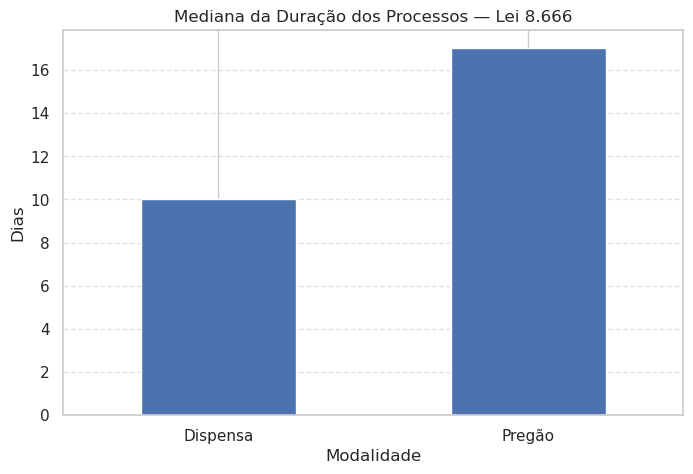

,Quantidade,Media_Dias,Mediana_Dias,P25,P75,Acima_6_Meses,Acima_1_Ano
Grupo_Modalidade,,,,,,,
Dispensa,2582,101.76,13.0,7.0,26.0,204,180
Pregão,34643,34.94,20.0,7.0,43.0,719,81


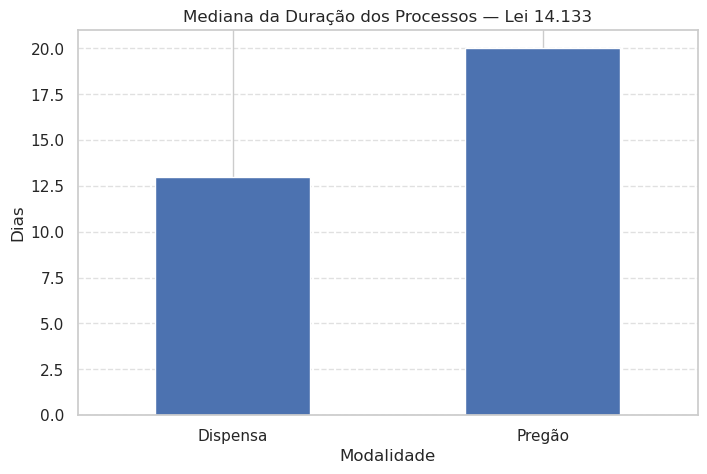

In [17]:
# Mediana da duração por modalidade — Lei 8.666
estatisticas_8666['Mediana_Dias'].plot(
    kind='bar',
    figsize=(8, 5),
    title='Mediana da Duração dos Processos — Lei 8.666',
    ylabel='Dias',
    xlabel='Modalidade'
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Estatísticas descritivas — Lei 14.133
estatisticas_14133 = (
    df_14133
    .groupby('Grupo_Modalidade')['Duracao_dias']
    .agg(
        Quantidade='count',
        Media_Dias='mean',
        Mediana_Dias='median',
        P25=lambda x: x.quantile(0.25),
        P75=lambda x: x.quantile(0.75),
        Acima_6_Meses=lambda x: (x > 180).sum(),
        Acima_1_Ano=lambda x: (x > 365).sum()
    )
    .round(2)
)

display(estatisticas_14133)

# Mediana da duração por modalidade — Lei 14.133
estatisticas_14133['Mediana_Dias'].plot(
    kind='bar',
    figsize=(8, 5),
    title='Mediana da Duração dos Processos — Lei 14.133',
    ylabel='Dias',
    xlabel='Modalidade'
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Síntese e Comparações

Comparações finais por período e gráficos por UF, destacando diferenças de duração.

As tabelas e gráficos finais consolidam os resultados por período e por UF,
permitindo localizar padrões persistentes e variações específicas.
A visualização por UF ajuda a detectar estados com processos mais longos ou mais rápidos.

Em geral, a modalidade de dispensa tende a apresentar durações diferentes das demais,
com variações relevantes entre períodos normativos e entre UFs.
A fase de transição (abr/2021–dez/2023) merece atenção especial por combinar regimes jurídicos distintos.
O recorte de 2024 mostra os primeiros sinais sob a Lei nº 14.133/2021, úteis para monitoramento contínuo.


In [19]:
# Dispensa em 2024
df_dispensa_2024 = df_2024[df_2024['Grupo_Modalidade'] == 'Dispensa']

display(df_dispensa_2024['Duracao_dias'].describe())

print(
    'Processos de Dispensa com duração superior a 1 ano:',
    (df_dispensa_2024['Duracao_dias'] > 365).sum()
)


count     185.000000
mean     1109.232432
std       523.552264
min        30.000000
25%       681.000000
50%      1242.000000
75%      1564.000000
max      1823.000000
Name: Duracao_dias, dtype: float64

Processos de Dispensa com duração superior a 1 ano: 164


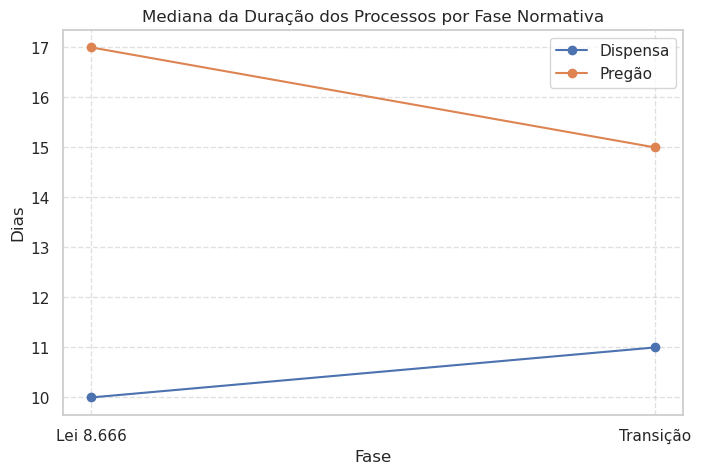

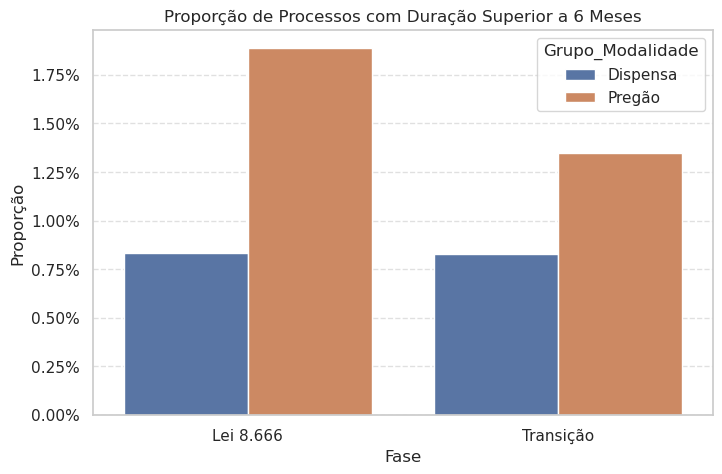

In [20]:
# Gráficos-síntese — Fases Normativas

# Mediana por fase e modalidade (Lei 8.666 e Transição)
dados_fases = pd.DataFrame({
    'Fase': [
        'Lei 8.666', 'Lei 8.666',
        'Transição', 'Transição'
    ],
    'Grupo_Modalidade': [
        'Dispensa', 'Pregão',
        'Dispensa', 'Pregão'
    ],
    'Mediana_Dias': [
        estatisticas_8666.loc['Dispensa', 'Mediana_Dias'],
        estatisticas_8666.loc['Pregão', 'Mediana_Dias'],
        estatisticas_transicao.loc['Dispensa', 'Mediana_Dias'],
        estatisticas_transicao.loc['Pregão', 'Mediana_Dias'],
    ]
})

plt.figure(figsize=(8, 5))
for modalidade in dados_fases['Grupo_Modalidade'].unique():
    subset = dados_fases[dados_fases['Grupo_Modalidade'] == modalidade]
    plt.plot(
        subset['Fase'],
        subset['Mediana_Dias'],
        marker='o',
        label=modalidade
    )

plt.title('Mediana da Duração dos Processos por Fase Normativa')
plt.ylabel('Dias')
plt.xlabel('Fase')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Proporção de processos acima de 6 meses
longos = pd.DataFrame({
    'Fase': [
        'Lei 8.666', 'Lei 8.666',
        'Transição', 'Transição',
        'Lei 14.133', 'Lei 14.133'
    ],
    'Grupo_Modalidade': [
        'Dispensa', 'Pregão',
        'Dispensa', 'Pregão',
        'Dispensa', 'Pregão'
    ],
    'Proporcao': [
        estatisticas_8666.loc['Dispensa', 'Acima_6_Meses'] / estatisticas_8666.loc['Dispensa', 'Quantidade'],
        estatisticas_8666.loc['Pregão', 'Acima_6_Meses'] / estatisticas_8666.loc['Pregão', 'Quantidade'],
        estatisticas_transicao.loc['Dispensa', 'Acima_6_Meses'] / estatisticas_transicao.loc['Dispensa', 'Quantidade'],
        estatisticas_transicao.loc['Pregão', 'Acima_6_Meses'] / estatisticas_transicao.loc['Pregão', 'Quantidade'],
        estatisticas_14133.loc['Dispensa', 'Acima_6_Meses'] / estatisticas_14133.loc['Dispensa', 'Quantidade'],
        estatisticas_14133.loc['Pregão', 'Acima_6_Meses'] / estatisticas_14133.loc['Pregão', 'Quantidade'],
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(
    data=longos,
    x='Fase',
    y='Proporcao',
    hue='Grupo_Modalidade'
)

plt.title('Proporção de Processos com Duração Superior a 6 Meses')
plt.ylabel('Proporção')
plt.xlabel('Fase')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

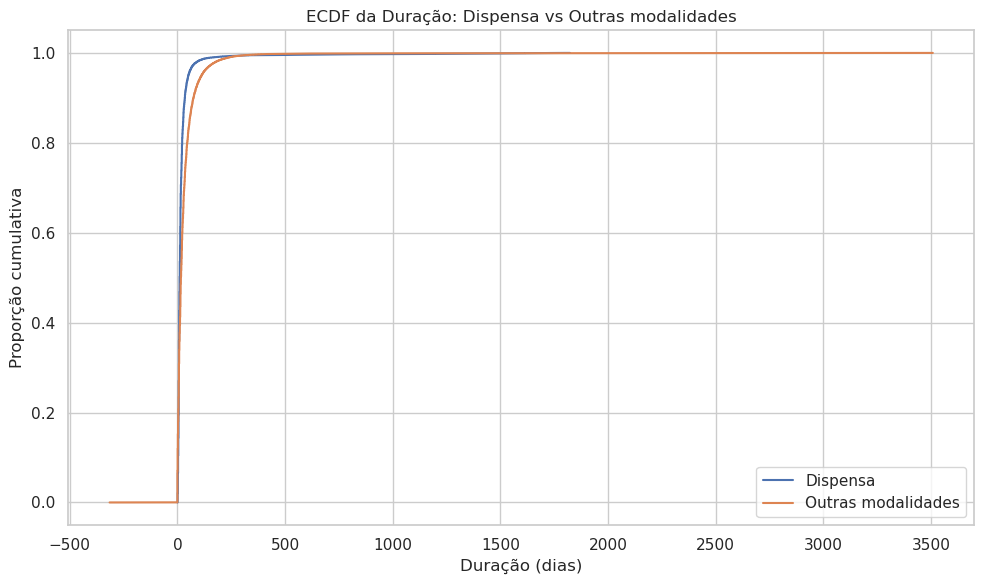

In [21]:
# 6) ECDF comparativa: Dispensa vs demais modalidades
plt.figure(figsize=(10, 6))
for label, filtro in [
    ('Dispensa', df['Grupo_Modalidade'] == 'Dispensa'),
    ('Outras modalidades', df['Grupo_Modalidade'] != 'Dispensa'),
]:
    dados = np.sort(df.loc[filtro, 'Duracao_dias'].dropna().values)
    if len(dados) == 0:
        continue
    y = np.arange(1, len(dados) + 1) / len(dados)
    plt.plot(dados, y, label=label)

plt.title('ECDF da Duração: Dispensa vs Outras modalidades')
plt.xlabel('Duração (dias)')
plt.ylabel('Proporção cumulativa')
plt.legend()
plt.tight_layout()
plt.show()
